## Musical Analysis of 10,000 Songs
    
    by Varun Nadgir

### The Problem

By analyzing the [Million Songs Dataset](https://think.cs.vt.edu/corgis/csv/music/music.html) (provided by Last.fm), I will be looking to classify artists/genres in a way to provide high quality recommendations. I will also be trying to analyze the frequency of terms used in song titles/album titles to find if there are common themes within and across genres. The audience for this analysis would be media companies such as Spotify, Soundcloud, YouTube, etc. that rely on good recommendations to keep their userbase.

### The Data

While the original dataset actually has a million songs (~300 GB), I will be working with a 10,000 song subset. This will be easier to handle for initial study and the code can always be repurposed to higher volume afterwards. The dataset also has 35 columns, with fields such as 'artist_name', 'title', 'duration', 'tempo', among other meta information about the song.

### Goals

I will first be looking at overall characteristics of artists and genres - that is, each artist or genre will be classified by their most common features. For example, rock music will most likely have a lot of the same key signatures set to a fast tempo. Using this, I would be able to recommend similar artists to users based on structural similarities in the music, as well as potentially introducing them to new genres that they have not explored but might still be similar. From my personal experience, this feeling of discovery is what causes users to stick around with the service.

Next, I would like to look at the terminology used in album and song titles, then check their frequency within a genre. This will help to identify themes or ideas that come up in one or many genres, and can also be used to recommend genres to people based on the types of topics involved. For example, both punk and rap deal with anti-establishment themes, which may be expressed through the used words.

### Importing Data

In [11]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.preprocessing import normalize, scale
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_selection import chi2

plt.rcParams['figure.figsize'] = (10, 6)

# read in csv
musicdf = pd.read_csv('songs.csv')

## Artist Clustering 

By using features such as song duration, key signature, major/minor, tempo, and time signature, I will be clustering artists by the musical make-up of their "discographies" (at least, what is available in the subset). Artists that share a similar musical structure will be grouped together, regardless of what genre they may be initially labeled as. This is a great way to recommend music to help listeners expand and explore, while still being relatively safe - we wouldn't want to recommend something slow and dark to someone who prefers faster and upbeat tunes.

For this clustering, I went with NMF since my values would be non-negative, and since it would be a simple way to check for closeness using the cosine similarity. The songs are being recommended on structural similarity alone without taking into consideration who or what genre the music is.  The continuous variables in the dataset were also scaled down.

In [2]:
# decide on which columns to use as features
artist_cols = ['artist_name', 'duration', 'key', 'mode', 'tempo', 'time_signature']
artist_df = musicdf[artist_cols]
artist_df.head()

,artist_name,duration,key,mode,tempo,time_signature
0,Casual,218.93179,1.0,0,92.198,4.0
1,The Box Tops,148.03546,6.0,0,121.274,4.0
2,Sonora Santanera,177.47546,8.0,1,100.070,1.0
3,Adam Ant,233.40363,0.0,1,119.293,4.0
4,Gob,209.60608,2.0,1,129.738,4.0


In [3]:
# look for any strange values
artist_df.describe() # duration of 22050 looks like an outlier

,duration,key,mode,tempo,time_signature
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,240.622038,5.366580,0.691000,122.900913,3.564443
std,246.084090,9.671788,0.462104,35.204746,1.266620
min,1.044440,0.000000,0.000000,0.000000,0.000000
25%,176.032200,2.000000,0.000000,96.959500,3.000000
50%,223.059140,5.000000,1.000000,120.156500,4.000000
75%,276.375060,8.000000,1.000000,144.006750,4.000000
max,22050.000000,904.802810,1.000000,262.828000,7.000000


In [4]:
# identify outlier
artist_df[artist_df['duration']==22050] # turns out it is the same one with key 904.80281 (not valid)

,artist_name,duration,key,mode,tempo,time_signature
6348,GAPteborgs Symfoniker / Neeme JA$?rvi,22050.0,904.80281,0,1.0,0.428


In [5]:
# drop outlier row
artist_df = artist_df.drop(6348)

artist_df.describe()

,duration,key,mode,tempo,time_signature
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,238.440882,5.276628,0.691069,122.913105,3.564756
std,113.948527,3.553873,0.462076,35.185390,1.266295
min,1.044440,0.000000,0.000000,0.000000,0.000000
25%,176.025670,2.000000,0.000000,96.964500,3.000000
50%,223.059140,5.000000,1.000000,120.160000,4.000000
75%,276.296690,8.000000,1.000000,144.008500,4.000000
max,1819.767710,11.000000,1.000000,262.828000,7.000000


In [6]:
# convert categorical features to dummy variables
artist_dummies = pd.get_dummies(artist_df, prefix=['key', 'mode', 'time_signature'], columns=['key', 'mode', 'time_signature'])

artist_dummies.head()

,artist_name,duration,tempo,key_0.0,key_1.0,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,...,key_10.0,key_11.0,mode_0,mode_1,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0,time_signature_7.0
0,Casual,218.93179,92.198,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,The Box Tops,148.03546,121.274,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2,Sonora Santanera,177.47546,100.070,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,Adam Ant,233.40363,119.293,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,Gob,209.60608,129.738,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [7]:
# prepare artist names and averages by artist
artists = artist_dummies['artist_name'].unique()

# to be able to better recommend, we should only consider artists with a minimum of N songs
group_count = artist_dummies.groupby('artist_name')

counts = []

for artist in artists:
    counts.append(group_count.get_group(artist)['artist_name'].count())
    
countsdf = pd.DataFrame(counts, index=artists, columns=['count'])
countsdf.reset_index(inplace=True)

countsdf.head()

,index,count
0,Casual,8
1,The Box Tops,4
2,Sonora Santanera,4
3,Adam Ant,5
4,Gob,2


In [8]:
# group features by artist
grouped_artists = artist_dummies.groupby('artist_name')

avgs = []

for artist in artists:
    avgs.append(grouped_artists.get_group(artist).mean().values)

In [9]:
# create dataframe
avgs_df = pd.DataFrame(avgs, index=artists, columns=artist_dummies.columns[1:24])

avgs_df.head()

,duration,tempo,key_0.0,key_1.0,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,key_7.0,...,key_10.0,key_11.0,mode_0,mode_1,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0,time_signature_7.0
Casual,222.445261,105.765875,0.125,0.125,0.125,0.0,0.375,0.0,0.00,0.00,...,0.125,0.125,0.375,0.625,0.0,0.25,0.00,0.625,0.125,0.0
The Box Tops,154.102402,110.799750,0.250,0.000,0.000,0.0,0.250,0.0,0.25,0.25,...,0.000,0.000,0.250,0.750,0.0,0.25,0.25,0.500,0.000,0.0
Sonora Santanera,166.092608,101.017500,0.250,0.000,0.500,0.0,0.000,0.0,0.00,0.00,...,0.000,0.000,0.500,0.500,0.0,0.50,0.00,0.250,0.250,0.0
Adam Ant,214.067792,123.424800,0.400,0.200,0.000,0.0,0.000,0.0,0.00,0.00,...,0.000,0.000,0.000,1.000,0.0,0.00,0.00,1.000,0.000,0.0
Gob,181.472200,131.862000,0.000,0.000,0.500,0.0,0.500,0.0,0.00,0.00,...,0.000,0.000,0.000,1.000,0.0,0.00,0.00,1.000,0.000,0.0


### Further Adjusting

My first time attempting to use the recommendations with this model, I noticed many artists would share close to 100% similarity to others, which raised some red flags due to some of my own knowledge of those artists. I realized this was because there are many artists who have only 1 song in this dataset - meaning if two artists happen to have similarly structured songs, they would be calculated as having very small distance between them. To avoid this, I decided to subset further and take only those artists with a minimum of 3 songs. Unfortunately, this does shrink the dataset quite a bit, but it is in the interest of keeping the models valuable. In the future, I would like to be able to run a similar study on a dataset with entire discographies.

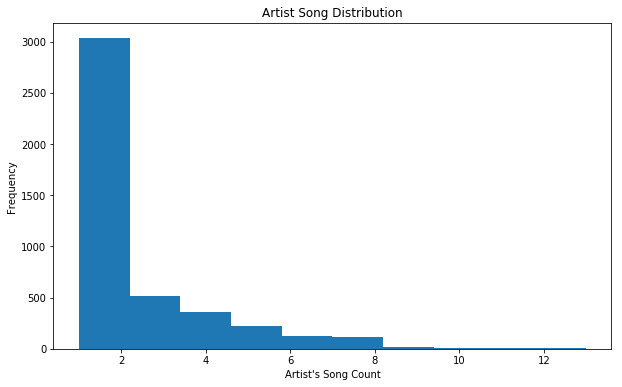

In [12]:
# plot histogram to be able to decide on N 
plt.hist(countsdf['count'])
plt.title('Artist Song Distribution')
plt.xlabel('Artist\'s Song Count')
plt.ylabel('Frequency')
plt.show() # perhaps a minimum of 3 is good

In [13]:
# get artist names with 3 or more songs
artists_highcounts = (countsdf[countsdf['count']>=3])['index']

# subset data to those artists
avgs_highcounts = avgs_df.loc[artists_highcounts]

In [14]:
# Create a MaxAbsScaler
scaler = MaxAbsScaler()

# Create an NMF
nmf = NMF()

# Create a normalizer
normalizer = Normalizer()

# Create a pipeline
pipeline = make_pipeline(scaler, nmf, normalizer)

# Apply fit_transform to artists
features = pipeline.fit_transform(avgs_highcounts)
features_df = pd.DataFrame(features, index=avgs_highcounts.index)

### Recommendations

In [15]:
# define function for recommending based on given artist
def recommend(artist):
    row = features_df.loc[artist]
    similarities = features_df.dot(row)
    return similarities.nlargest(10)

In [16]:
# check an artist I am familiar with
recommend('Radiohead')

Radiohead        1.000000
Muse             0.969269
Jesus Jones      0.948365
Mavado           0.947596
STEVE CAMP       0.946154
William Orbit    0.945373
LeA3n Gieco      0.945020
Frank Stokes     0.944841
Behemoth         0.943851
Akon             0.943411
dtype: float64

## Genre Clustering

By using the same features as the artists, we can also cluster genres to find which genres may share qualities. This is a good way of recommending songs by combining what we learn from multiple models - if two artists have high cosine similarity and their genres are also within the same cluster, that recommendation can have higher priority than two artists with genres in separate clusters.

For this clustering, I used hierarchical clustering (with dendrograms) and K-Means clustering (with inertia plots) to look for an ideal number of clusters, then applied labels to the genres. Ideally, a clustering like this would be used in tandem with the artists' song similarities, with the advantage that they could also be used separately when the listener was feeling "adventurous". 

In [17]:
# decide on which columns to use as features
genre_cols = ['terms', 'duration', 'key', 'mode', 'tempo', 'time_signature']
genre_df = musicdf[genre_cols]
genre_df.head()

,terms,duration,key,mode,tempo,time_signature
0,hip hop,218.93179,1.0,0,92.198,4.0
1,blue-eyed soul,148.03546,6.0,0,121.274,4.0
2,salsa,177.47546,8.0,1,100.070,1.0
3,pop rock,233.40363,0.0,1,119.293,4.0
4,pop punk,209.60608,2.0,1,129.738,4.0


In [18]:
# drop the same outlier row
genre_df = genre_df.drop(6348)

In [19]:
# convert categorical features to dummy variables
genre_dummies = pd.get_dummies(genre_df, prefix=['key', 'mode', 'time_signature'], columns=['key', 'mode', 'time_signature'])

genre_dummies.head()

,terms,duration,tempo,key_0.0,key_1.0,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,...,key_10.0,key_11.0,mode_0,mode_1,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0,time_signature_7.0
0,hip hop,218.93179,92.198,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,blue-eyed soul,148.03546,121.274,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2,salsa,177.47546,100.070,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,pop rock,233.40363,119.293,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,pop punk,209.60608,129.738,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [21]:
# group features by genre
grouped_genres = genre_dummies.groupby('terms')

# prepare genre names and averages by genre
genres = [genre for genre in grouped_genres.groups.keys()]

avgs = []

for genre in grouped_genres.groups.keys():
    values = list(grouped_genres.get_group(genre).mean().values)
    avgs.append(values)

In [22]:
# create dataframe
genre_avgs_df = pd.DataFrame(avgs, index=genres, columns=genre_dummies.columns[1:23])

genre_avgs_df.head()

,duration,tempo,key_0.0,key_1.0,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,key_7.0,...,key_10.0,key_11.0,mode_0,mode_1,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0,time_signature_7.0
8-bit,271.320365,115.592000,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.0,0.000000,...,0.000000,0.50,1.000000,0.000000,0.0,0.00,0.500000,0.500000,0.000000,0.0
acid jazz,171.676280,91.958750,0.000000,0.000000,0.250000,0.0,0.500000,0.000000,0.0,0.000000,...,0.000000,0.25,0.250000,0.750000,0.0,0.25,0.000000,0.750000,0.000000,0.0
afrobeat,351.126310,112.730571,0.142857,0.142857,0.000000,0.0,0.142857,0.000000,0.0,0.571429,...,0.000000,0.00,0.142857,0.857143,0.0,0.00,0.142857,0.857143,0.000000,0.0
all-female,156.452116,114.544800,0.200000,0.000000,0.000000,0.0,0.000000,0.200000,0.4,0.000000,...,0.000000,0.20,0.000000,1.000000,0.0,0.00,0.000000,1.000000,0.000000,0.0
alternative,215.509751,140.071286,0.000000,0.285714,0.428571,0.0,0.000000,0.142857,0.0,0.000000,...,0.142857,0.00,0.285714,0.714286,0.0,0.00,0.000000,0.857143,0.142857,0.0


In [23]:
# take slice of continuous and dummy variables
genre_avgs_left = genre_avgs_df.iloc[:,0:2]
genre_avgs_right = genre_avgs_df.iloc[:,2:]

# apply scaling to continuous variables, then rejoin data
genre_avgs_left = pd.DataFrame(scale(genre_avgs_left), index=genre_avgs_left.index, columns=genre_avgs_left.columns)
genre_avgs_scaled = genre_avgs_left.join(genre_avgs_right)

genre_avgs_scaled.head()

,duration,tempo,key_0.0,key_1.0,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,key_7.0,...,key_10.0,key_11.0,mode_0,mode_1,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0,time_signature_7.0
8-bit,0.415099,-0.312535,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.0,0.000000,...,0.000000,0.50,1.000000,0.000000,0.0,0.00,0.500000,0.500000,0.000000,0.0
acid jazz,-0.947447,-1.506871,0.000000,0.000000,0.250000,0.0,0.500000,0.000000,0.0,0.000000,...,0.000000,0.25,0.250000,0.750000,0.0,0.25,0.000000,0.750000,0.000000,0.0
afrobeat,1.506375,-0.457141,0.142857,0.142857,0.000000,0.0,0.142857,0.000000,0.0,0.571429,...,0.000000,0.00,0.142857,0.857143,0.0,0.00,0.142857,0.857143,0.000000,0.0
all-female,-1.155624,-0.365457,0.200000,0.000000,0.000000,0.0,0.000000,0.200000,0.4,0.000000,...,0.000000,0.20,0.000000,1.000000,0.0,0.00,0.000000,1.000000,0.000000,0.0
alternative,-0.348063,0.924557,0.000000,0.285714,0.428571,0.0,0.000000,0.142857,0.0,0.000000,...,0.142857,0.00,0.285714,0.714286,0.0,0.00,0.000000,0.857143,0.142857,0.0


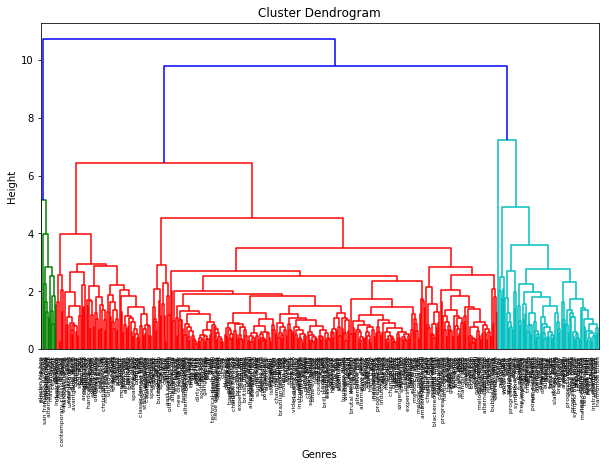

In [33]:
# generate mergings and dendrogram
mergings = linkage(genre_avgs_scaled, method='complete')
dendrogram(mergings, labels=genre_avgs_scaled.index, leaf_rotation=90, leaf_font_size=6)

plt.title('Cluster Dendrogram')
plt.xlabel('Genres')
plt.ylabel('Height')
plt.show()

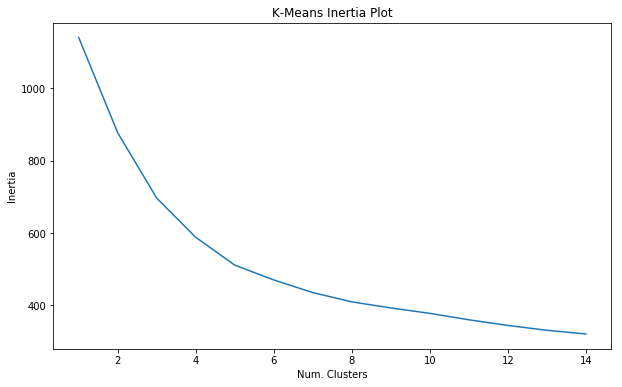

In [26]:
# set K range for KMeans, initialize empty list for storing inertia
Ks = range(1,15)
inertias = []

# loop through K range and run clustering, store inertia
for K in Ks:
    model = KMeans(n_clusters=K)
    model.fit(genre_avgs_scaled)
    inertias.append(model.inertia_)
    
plt.title('K-Means Inertia Plot')
plt.xlabel('Num. Clusters')
plt.ylabel('Inertia')
plt.plot(Ks, inertias)
plt.show()

It is hard to decipher an ideal cluster amount from either the dendrogram or inertia plot. There is no distinct elbow point, and the inertia is still fairly high as we get to 15 clusters (and any more would start to be too many). It may just be better to do some reduction at the beginning and go from there.

### More Adjusting

I also ran into a similar problem with genres as I did with the artists - there were a large portion of genres that were only represented once. Though they may have shared words (ex: metal, death metal, doom metal, heavy metal, etc), they do not necessarily group together algorithmically. After plotting the distribution of genre counts, I chose 50 as the number of times a genre would need to be represented.

In [27]:
# get counts of each genre, put in a dataframe
genrecounts = genre_dummies.groupby('terms')['terms'].count().sort_values(ascending=False)
genrecountdf = pd.DataFrame(genrecounts.values, index=genrecounts.index, columns=['counts'])
genrecountdf = genrecountdf.reset_index()

genrecountdf.head()

,terms,counts
0,hip hop,346
1,blues-rock,346
2,ccm,255
3,chanson,208
4,country rock,156


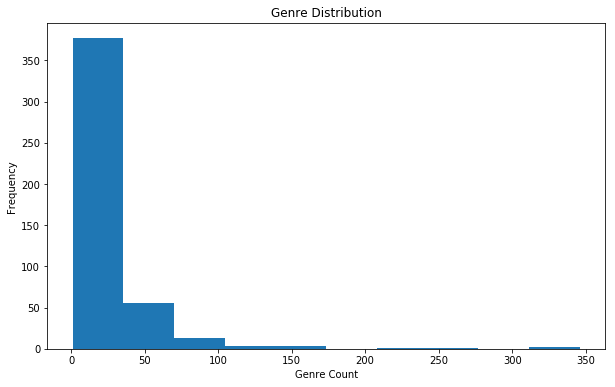

In [28]:
plt.title('Genre Distribution')
plt.xlabel('Genre Count')
plt.ylabel('Frequency')
plt.hist(genrecountdf['counts'])
plt.show()

In [30]:
# get genres names with 50 or more entries
genres_highcounts = (genrecountdf[genrecountdf['counts']>=50])['terms']

# subset data to those genres
genres_avgs_highcounts = genre_avgs_scaled.loc[genres_highcounts]

# see how many we are left with
len(genres_avgs_highcounts)

47

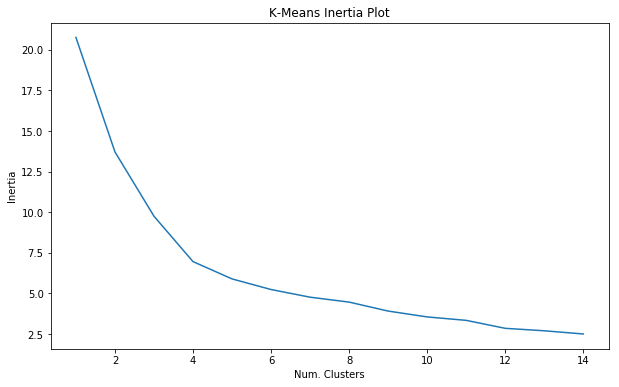

In [32]:
# set K range for KMeans, initialize empty list for storing inertia
Ks = range(1,15)
inertias = []

# loop through K range and run clustering, store inertia
for K in Ks:
    model = KMeans(n_clusters=K)
    model.fit(genres_avgs_highcounts)
    inertias.append(model.inertia_)
    
plt.title('K-Means Inertia Plot')
plt.xlabel('Num. Clusters')
plt.ylabel('Inertia')
plt.plot(Ks, inertias)
plt.show()

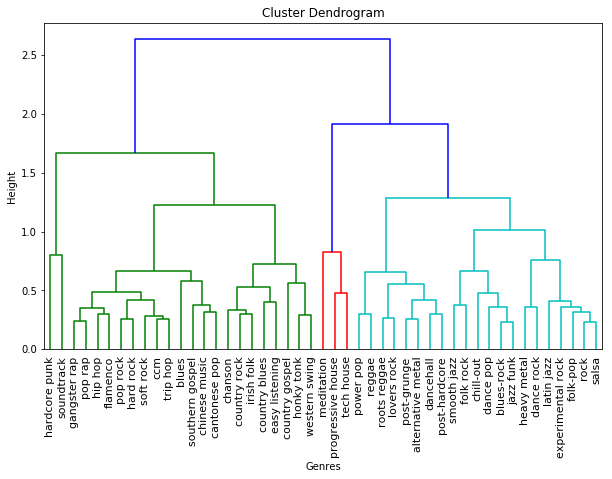

In [34]:
# generate mergings and dendrogram
mergings = linkage(genres_avgs_highcounts, method='complete')
dendrogram(mergings, labels=genres_avgs_highcounts.index, leaf_rotation=90, leaf_font_size=11)

plt.title('Cluster Dendrogram')
plt.xlabel('Genres')
plt.ylabel('Height')
plt.show()

In [38]:
# set height at 0.6 and apply cluster labels
labels = fcluster(mergings, 0.6, criterion='distance')

# create dataframe of labels and genres
genre_labels = pd.DataFrame({'labels':labels, 'genres':genres_highcounts})

genre_labels.sort_values('labels')

,labels,genres
19,1,hardcore punk
29,2,soundtrack
0,3,hip hop
2,3,ccm
41,3,soft rock
39,3,flamenco
35,3,pop rap
8,3,gangster rap
34,3,trip hop
10,3,pop rock


## Word Frequency Analysis

By using TFIDF to construct a word frequency array and the $\chi^2$-test to find the most highly related features, we can see what topics come up the most for each genre. This gives us a better idea of what it is about certain genres that people enjoy and, in turn, we can recommend other genres that may have topic overlap. One area that I would like to improve is the handling of stopwords in other languages. In this study, I took the time to add French stopwords since I noticed a few, but I was not able to catch Chinese stopwords since they were in an Anglicized form. For this reason, the final result is of mixed quality - some of the genres have quite sensible terms while others do not make as much sense.

In [40]:
# select text columns
words_cols = ['terms', 'release_name', 'title']
wordsdf = musicdf[words_cols]

# filter those genres that have > 50 count
wordsdf = wordsdf[wordsdf['terms'].isin(genres_highcounts)]
wordsdf = wordsdf.reset_index(drop=True)

wordsdf.head()

,terms,release_name,title
0,hip hop,Fear Itself,I Didn't Mean To
1,salsa,Las Numero 1 De La Sonora Santanera,Amor De Cabaret
2,pop rock,Friend Or Foe,Something Girls
3,southern gospel,Ordinary Day,The Moon And I (Ordinary Day Album Version)
4,post-hardcore,Gin & Phonic,Drop of Rain


In [41]:
# initialize new column 
wordsdf['allwords'] = ''

# loop through words df and combine album and song title into a single string, store in new column
for i in range(len(wordsdf)):
    string = str(wordsdf['release_name'][i] + ' ' + wordsdf['title'][i])
    wordsdf['allwords'][i] = string

# drop original columns
wordsdf = wordsdf.drop(['release_name', 'title'], axis=1)

wordsdf.head()

,terms,allwords
0,hip hop,Fear Itself I Didn't Mean To
1,salsa,Las Numero 1 De La Sonora Santanera Amor De Ca...
2,pop rock,Friend Or Foe Something Girls
3,southern gospel,Ordinary Day The Moon And I (Ordinary Day Albu...
4,post-hardcore,Gin & Phonic Drop of Rain


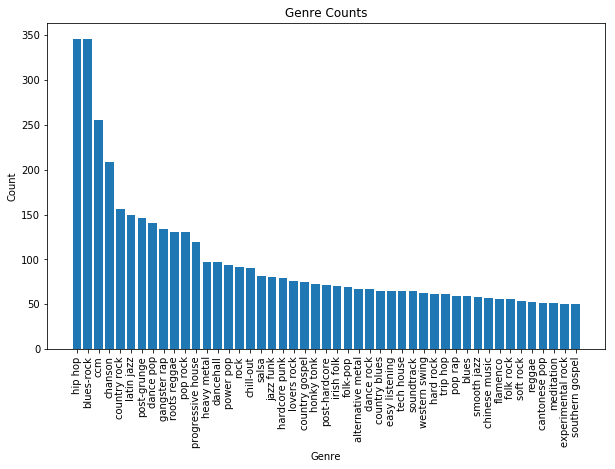

In [45]:
# group by genre
wordgroups = wordsdf.groupby('terms')

# get counts of each genre present
wordgroups_counts = pd.DataFrame(wordgroups.count().sort_values('allwords', ascending=False)).reset_index()

plt.title('Genre Counts')
plt.xlabel('Genre')
plt.xticks(rotation=90, size=10)
plt.ylabel('Count')
plt.bar(wordgroups_counts['terms'], wordgroups_counts['allwords'])
plt.show()

In [46]:
# translate genres into numerical ID
wordsdf['genre_id'] = wordsdf['terms'].factorize()[0]

# create df that indicates which ID belongs to which genre
genre_id_df = wordsdf[['terms', 'genre_id']].drop_duplicates().sort_values('genre_id')

# create two dicts, one for genres to ID and vice versa
genre_to_id = dict(genre_id_df.values)
id_to_genre = dict(genre_id_df[['genre_id', 'terms']].values)

wordsdf.head()

,terms,allwords,genre_id
0,hip hop,Fear Itself I Didn't Mean To,0
1,salsa,Las Numero 1 De La Sonora Santanera Amor De Ca...,1
2,pop rock,Friend Or Foe Something Girls,2
3,southern gospel,Ordinary Day The Moon And I (Ordinary Day Albu...,3
4,post-hardcore,Gin & Phonic Drop of Rain,4


In [98]:
# add words that occur in genre names to stopwords
term_words = [term for term in wordsdf['terms'].unique()]
my_stopwords = []

for term in term_words:
    temp = str(term).split()
    for w in temp:
        if w not in my_stopwords:
            my_stopwords.append(w)

In [47]:
FRENCH_STOP_WORDS = ['alors','au','aucuns','aussi','autre','avant','avec','avoir','bon','car','ce','cela','ces','ceux',
'chaque','ci','comme','comment','dans','des','du','dedans','dehors','depuis','devrait','doit','donc',
'dos','début','elle','elles','en','encore','essai','est','et','eu','fait','faites','fois','font','hors',
'ici','il','ils','je','juste','la','le','les','leur','là','ma','maintenant','mais','mes','mine','moins',
'mon','mot','même','ni','nommés','notre','nous','ou','où','par','parce','pas','peut','peu','plupart',
'pour','pourquoi','quand','que','quel','quelle','quelles','quels','qui','sa','sans','ses','seulement',
'si','sien','son','sont','sous','soyez','sujet','sur','ta','tandis','tellement','tels','tes','ton','tous',
'tout','trop','très','tu','voient','vont','votre','vous','vu','ça','étaient','état','étions','été','être']

In [93]:
# combine the stock stopwords with french stopwords
custom_stopwords = text.ENGLISH_STOP_WORDS.union(FRENCH_STOP_WORDS).union(my_stopwords)

# create TFIDF object
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                        encoding='latin-1', ngram_range=(1,1), stop_words=custom_stopwords)

In [94]:
# generate TFIDF features, assign labels as genre ID
features = tfidf.fit_transform(wordsdf['allwords']).toarray()
labels = wordsdf['genre_id']

# see 788 features kept 
features.shape

(4641, 788)

In [101]:
# get top 5 terms for each genre
N = 5
for term, genre_id in sorted(genre_to_id.items()):
    features_chi2 = chi2(features, labels == genre_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    print("# '{}':".format(term))
    print("  . Most correlated terms:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("-----------------------------")

# 'alternative metal':
  . Most correlated terms:
. death
. special
. album
. demo
. healing
-----------------------------
# 'blues':
  . Most correlated terms:
. mo
. 12
. cold
. martin
. sessions
-----------------------------
# 'blues-rock':
  . Most correlated terms:
. brown
. retrospective
. blues_
. crazy
. walk
-----------------------------
# 'cantonese pop':
  . Most correlated terms:
. bu
. zai
. ai
. yu
. shou
-----------------------------
# 'ccm':
  . Most correlated terms:
. premiere
. album
. version
. performance
. god
-----------------------------
# 'chanson':
  . Most correlated terms:
. inta
. grale
. bam
. amour
. chansons
-----------------------------
# 'chill-out':
  . Most correlated terms:
. goes
. earth
. dawn
. sent
. edge
-----------------------------
# 'chinese music':
  . Most correlated terms:
. wo
. ji
. 700
. li
. yi
-----------------------------
# 'country blues':
  . Most correlated terms:
. artists
. cd
. blind
. 1927
. memphis
--------------------------

## Conclusion

These three approaches to identifying patterns and similarities are potential ways to give great recommendations to music listeners and, hopefully, retain their membership. By clustering artists and genres, we can find songs that are a structural match, as well as having closely related genres. We can also use the most frequent terms to find topics that listeners enjoy and use that to find new songs that may share those topics.

As a musician myself, it is very satisfying to see the different ways that music is interconnected. If you have any questions on how I performed this analysis, or suggestions on ways I can improve, feel free to [email me](mailto:vanadgir@gmail.com). Thanks again to Last.fm for collecting and providing this data, and thank you for reading.